# LAB 01: Phân loại văn bản AG News với FastAPI
## Dataset: AG News Classification
- 4 categories: World, Sports, Business, Sci/Tech
- Training: 120,000 samples
- Testing: 7,600 samples

## 1. Cài đặt các thư viện cần thiết

In [1]:
!pip install -q datasets transformers torch scikit-learn pandas numpy matplotlib seaborn
!pip install -q fastapi uvicorn pydantic wandb wordcloud nltk plotly

In [2]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pickle
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

## 2. Khởi tạo WandB để theo dõi thí nghiệm

In [3]:
# Login to WandB
wandb.login()

# Initialize WandB project
wandb.init(
    project="ag-news-classification",
    name="logistic-regression-tfidf",
    config={
        "dataset": "ag_news",
        "model": "LogisticRegression",
        "vectorizer": "TfidfVectorizer",
        "max_features": 10000,
        "test_size": 0.2
    }
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: builehongtamk16 (builehongtamk16-hi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 3. Tải và khám phá dữ liệu

In [4]:
# Load AG News dataset
print("Loading AG News dataset...")
dataset = load_dataset('ag_news')

# Convert to pandas DataFrame
train_data = pd.DataFrame(dataset['train'])
test_data = pd.DataFrame(dataset['test'])

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")
print(f"\nColumns: {train_data.columns.tolist()}")

Loading AG News dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Training samples: 120000
Testing samples: 7600

Columns: ['text', 'label']


In [5]:
# Display first few samples
print("\n=== Sample Data ===")
train_data.head()


=== Sample Data ===


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [6]:
# Check data info
print("\n=== Data Info ===")
train_data.info()


=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
 1   label   120000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [7]:
# Check for missing values
print("\n=== Missing Values ===")
print(train_data.isnull().sum())
print(test_data.isnull().sum())


=== Missing Values ===
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [8]:
# Label distribution
label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
train_data['label_name'] = train_data['label'].map(label_names)
test_data['label_name'] = test_data['label'].map(label_names)

print("\n=== Label Distribution (Training) ===")
print(train_data['label_name'].value_counts())


=== Label Distribution (Training) ===
label_name
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


## 4. Trực quan hóa dữ liệu

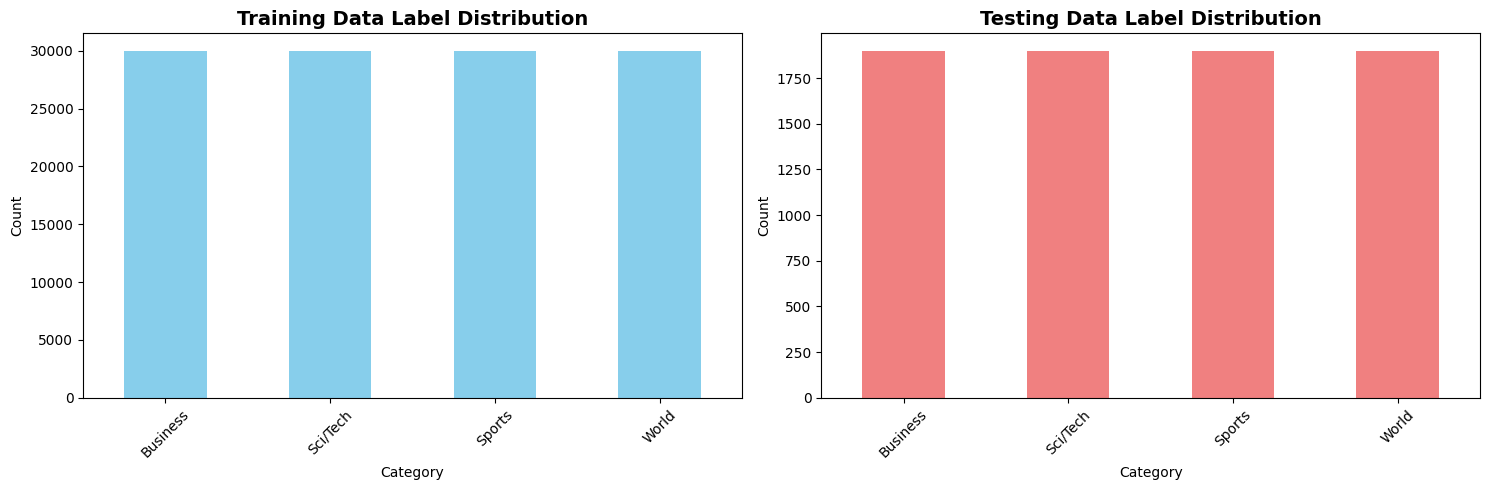

In [9]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training data
train_data['label_name'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Data Label Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Testing data
test_data['label_name'].value_counts().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Testing Data Label Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({"label_distribution": wandb.Image('label_distribution.png')})

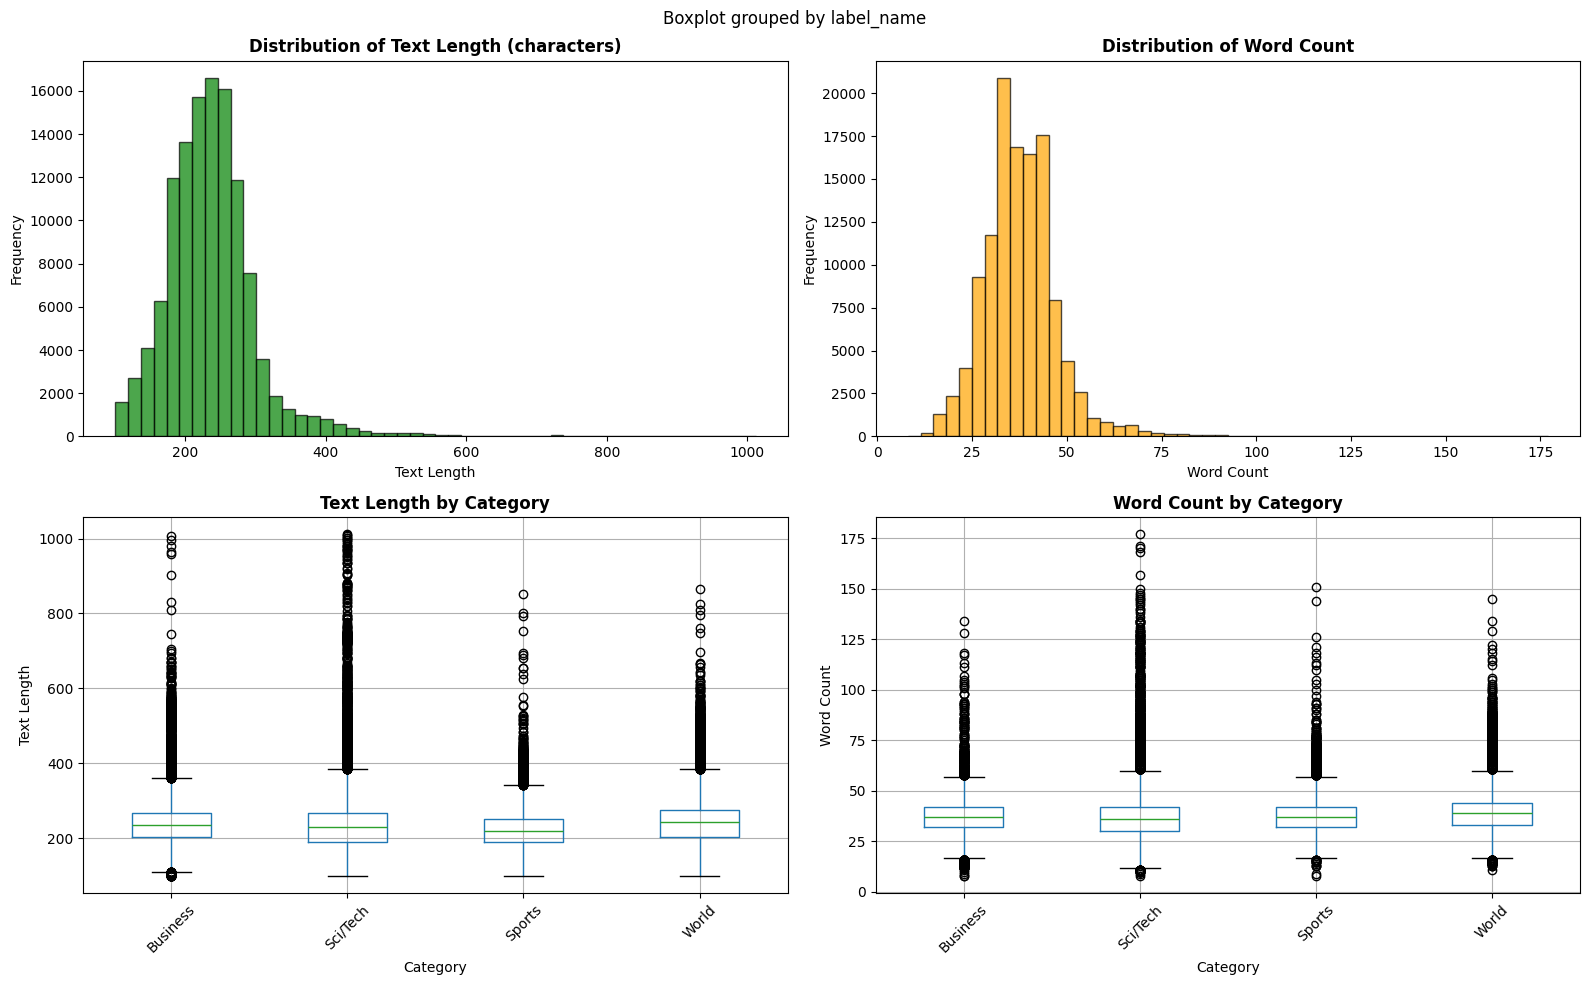

In [10]:
# Text length analysis
train_data['text_length'] = train_data['text'].apply(len)
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Text length distribution
axes[0, 0].hist(train_data['text_length'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Text Length (characters)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Text Length')
axes[0, 0].set_ylabel('Frequency')

# Word count distribution
axes[0, 1].hist(train_data['word_count'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Word Count', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

# Text length by category
train_data.boxplot(column='text_length', by='label_name', ax=axes[1, 0])
axes[1, 0].set_title('Text Length by Category', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Text Length')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# Word count by category
train_data.boxplot(column='word_count', by='label_name', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Category', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Category')
axes[1, 1].set_ylabel('Word Count')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('text_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"text_statistics": wandb.Image('text_statistics.png')})

In [11]:
# Statistical summary
print("\n=== Text Statistics ===")
print(train_data[['text_length', 'word_count']].describe())

# Log statistics to WandB
wandb.log({
    "avg_text_length": train_data['text_length'].mean(),
    "avg_word_count": train_data['word_count'].mean(),
    "max_text_length": train_data['text_length'].max(),
    "min_text_length": train_data['text_length'].min()
})


=== Text Statistics ===
         text_length     word_count
count  120000.000000  120000.000000
mean      236.477525      37.847450
std        66.509741      10.085245
min       100.000000       8.000000
25%       196.000000      32.000000
50%       232.000000      37.000000
75%       266.000000      43.000000
max      1012.000000     177.000000


## 5. Tiền xử lý dữ liệu

In [12]:
# Text preprocessing function
def preprocess_text(text):
    """
    Preprocess text data:
    - Convert to lowercase
    - Remove special characters and digits
    - Remove extra whitespaces
    - Remove stopwords
    """
    # Lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]

    return ' '.join(words)

In [14]:
# Apply preprocessing with tqdm progress bar
from tqdm.auto import tqdm
tqdm.pandas()

print("Preprocessing training data...")
train_data['text_clean'] = train_data['text'].progress_apply(preprocess_text)

print("Preprocessing testing data...")
test_data['text_clean'] = test_data['text'].progress_apply(preprocess_text)

print("\nPreprocessing completed!")

Preprocessing training data...


  0%|          | 0/120000 [00:00<?, ?it/s]

Preprocessing testing data...


  0%|          | 0/7600 [00:00<?, ?it/s]


Preprocessing completed!


In [15]:
# Compare original and cleaned text
print("\n=== Text Preprocessing Comparison ===")
for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(f"Original: {train_data.iloc[i]['text'][:200]}...")
    print(f"Cleaned: {train_data.iloc[i]['text_clean'][:200]}...")


=== Text Preprocessing Comparison ===

--- Example 1 ---
Original: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....
Cleaned: wall bears claw back black reuters reuters shortsellers wall streets dwindlingband ultracynics seeing green...

--- Example 2 ---
Original: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense in...
Cleaned: carlyle looks toward commercial aerospace reuters reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial plays defense industry quietly placedits bets...

--- Example 3 ---
Original: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next we

## 6. Trực quan hóa từ phổ biến (Word Cloud)

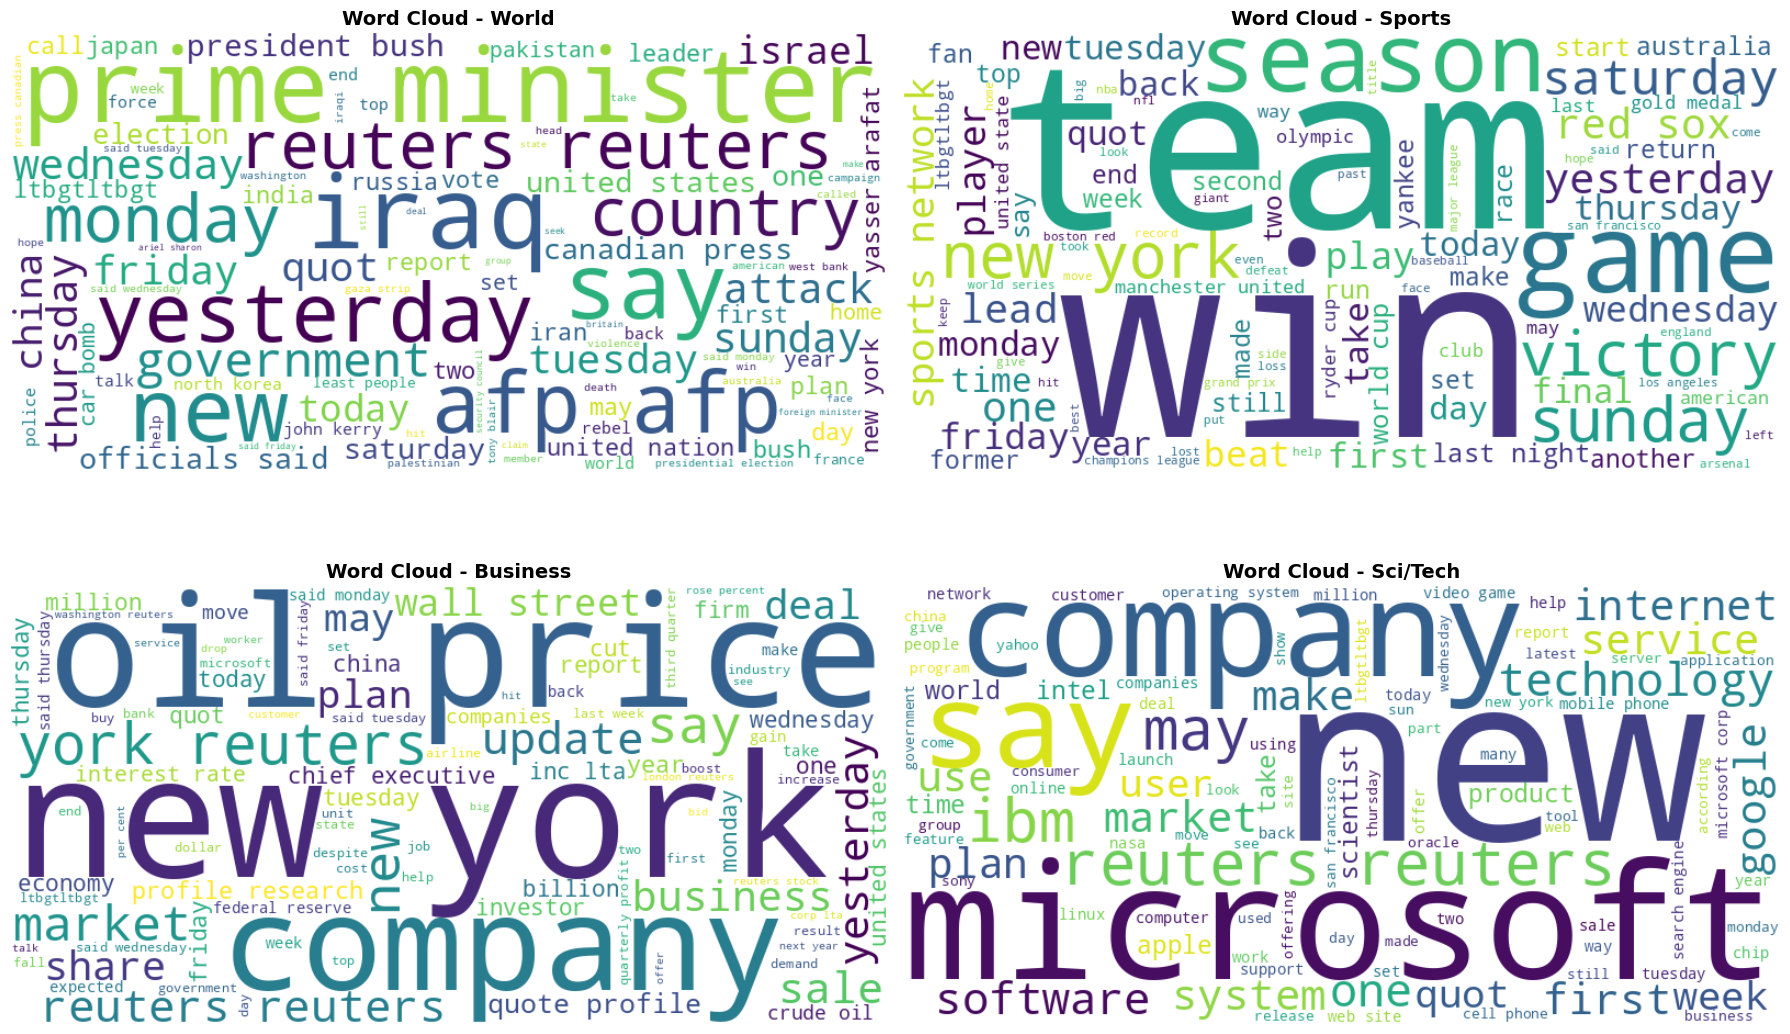

In [16]:
# Generate word clouds for each category
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for idx, (label, name) in enumerate(label_names.items()):
    # Get text for this category
    category_text = ' '.join(train_data[train_data['label'] == label]['text_clean'].tolist())

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         colormap='viridis',
                         max_words=100).generate(category_text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud - {name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('wordcloud_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"wordcloud_by_category": wandb.Image('wordcloud_by_category.png')})

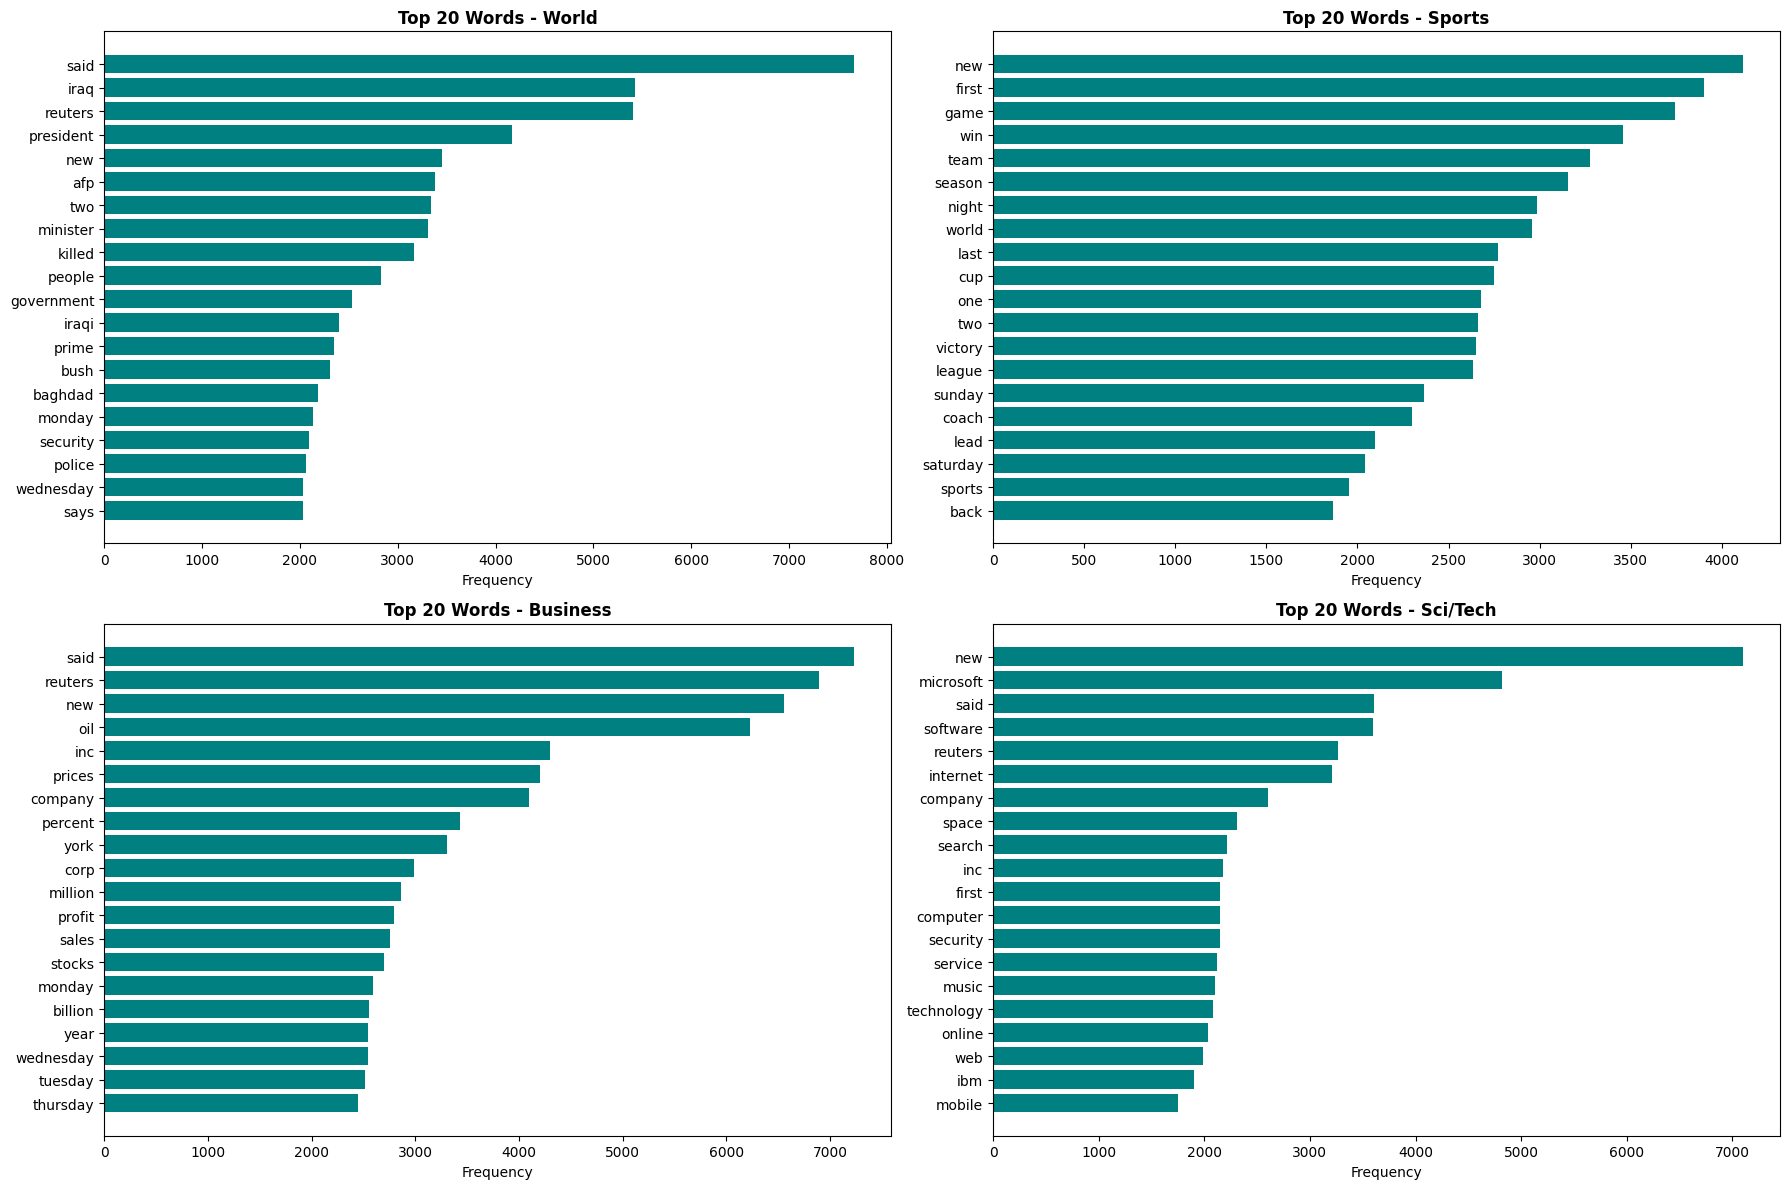

In [17]:
# Top words by category
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for idx, (label, name) in enumerate(label_names.items()):
    # Get text for this category
    category_text = ' '.join(train_data[train_data['label'] == label]['text_clean'].tolist())
    words = category_text.split()

    # Count words
    word_freq = Counter(words)
    top_words = dict(word_freq.most_common(20))

    # Plot
    axes[idx].barh(list(top_words.keys()), list(top_words.values()), color='teal')
    axes[idx].set_title(f'Top 20 Words - {name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Frequency')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig('top_words_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"top_words_by_category": wandb.Image('top_words_by_category.png')})

## 7. Trích xuất đặc trưng (Feature Engineering)

In [18]:
# TF-IDF Vectorization
print("Creating TF-IDF features...")
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

# Fit on training data
X_train_tfidf = vectorizer.fit_transform(train_data['text_clean'])
X_test_tfidf = vectorizer.transform(test_data['text_clean'])

y_train = train_data['label'].values
y_test = test_data['label'].values

print(f"\nTraining features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

Creating TF-IDF features...

Training features shape: (120000, 10000)
Testing features shape: (7600, 10000)
Vocabulary size: 10000


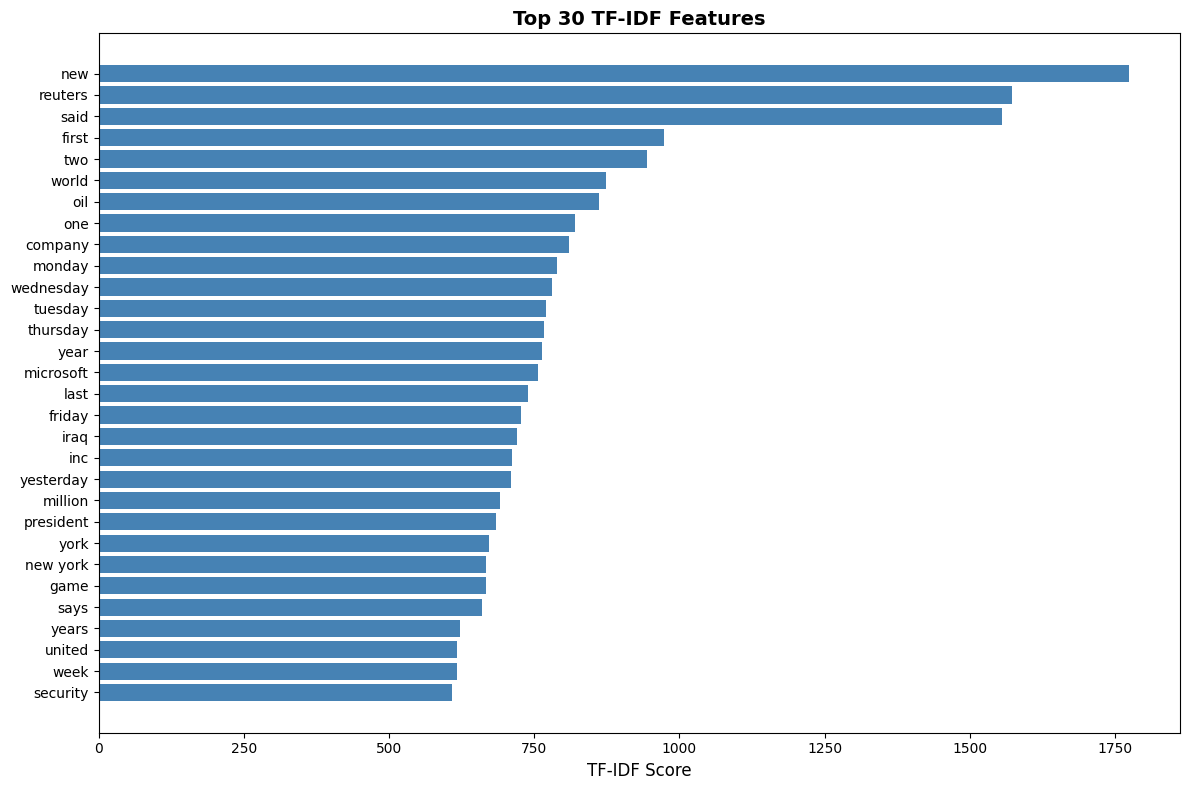

In [19]:
# Visualize TF-IDF feature importance
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = X_train_tfidf.toarray().sum(axis=0)
top_features_idx = tfidf_scores.argsort()[-30:][::-1]

plt.figure(figsize=(12, 8))
plt.barh([feature_names[i] for i in top_features_idx],
         [tfidf_scores[i] for i in top_features_idx],
         color='steelblue')
plt.xlabel('TF-IDF Score', fontsize=12)
plt.title('Top 30 TF-IDF Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('tfidf_top_features.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"tfidf_top_features": wandb.Image('tfidf_top_features.png')})

## 8. Xây dựng và huấn luyện mô hình

In [20]:
# Define models to compare
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

In [21]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")

    # Train
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred_train = model.predict(X_train_tfidf)
    y_pred_test = model.predict(X_test_tfidf)

    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy: {test_acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test,
                                target_names=list(label_names.values())))

    # Store results
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'y_pred': y_pred_test
    }

    # Log to WandB
    wandb.log({
        f"{name}_train_accuracy": train_acc,
        f"{name}_test_accuracy": test_acc
    })


Training Naive Bayes...
Training Accuracy: 0.9048
Testing Accuracy: 0.8934

Classification Report:
              precision    recall  f1-score   support

       World       0.90      0.89      0.90      1900
      Sports       0.94      0.97      0.96      1900
    Business       0.87      0.84      0.85      1900
    Sci/Tech       0.86      0.87      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


Training Logistic Regression...
Training Accuracy: 0.9305
Testing Accuracy: 0.9121

Classification Report:
              precision    recall  f1-score   support

       World       0.93      0.90      0.92      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.88      0.88      0.88      1900
    Sci/Tech       0.89      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.

## 9. So sánh hiệu suất các mô hình


=== Model Comparison ===
                 Model  Training Accuracy  Testing Accuracy
0          Naive Bayes           0.904767          0.893421
1  Logistic Regression           0.930533          0.912105
2        Random Forest           0.999242          0.888289


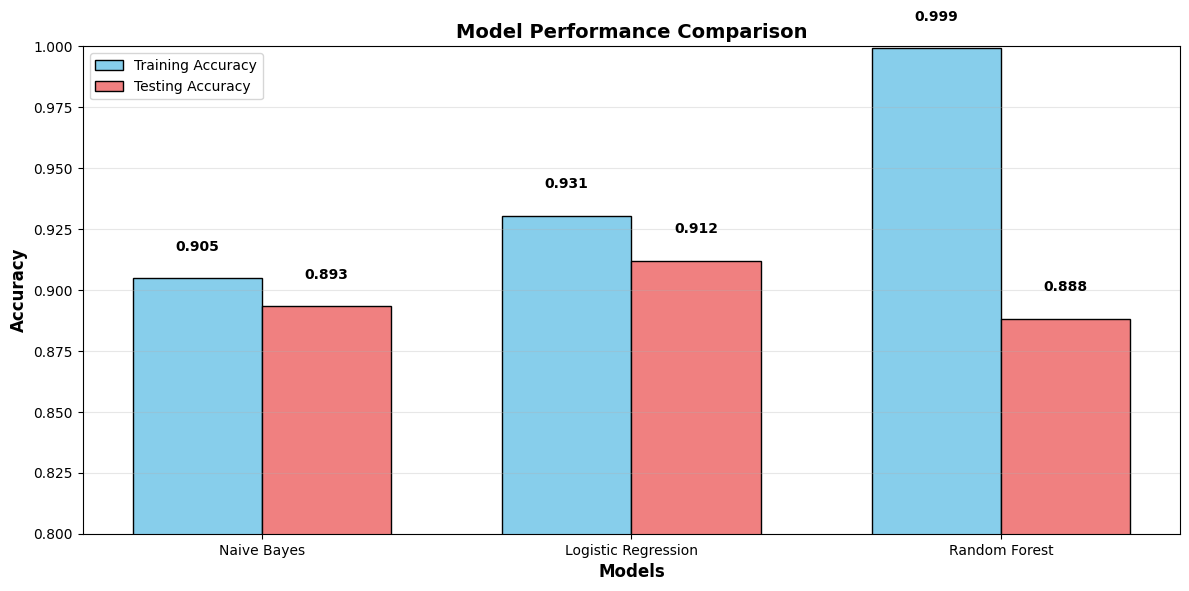

In [22]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Training Accuracy': [results[m]['train_acc'] for m in results.keys()],
    'Testing Accuracy': [results[m]['test_acc'] for m in results.keys()]
})

print("\n=== Model Comparison ===")
print(comparison_df)

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Training Accuracy'], width,
       label='Training Accuracy', color='skyblue', edgecolor='black')
ax.bar(x + width/2, comparison_df['Testing Accuracy'], width,
       label='Testing Accuracy', color='lightcoral', edgecolor='black')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (train, test) in enumerate(zip(comparison_df['Training Accuracy'],
                                       comparison_df['Testing Accuracy'])):
    ax.text(i - width/2, train + 0.01, f'{train:.3f}',
            ha='center', va='bottom', fontweight='bold')
    ax.text(i + width/2, test + 0.01, f'{test:.3f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"model_comparison": wandb.Image('model_comparison.png')})

## 10. Đánh giá chi tiết mô hình tốt nhất

In [23]:
# Select best model
best_model_name = max(results, key=lambda x: results[x]['test_acc'])
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred']

print(f"\n{'='*50}")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['test_acc']:.4f}")
print(f"{'='*50}")


Best Model: Logistic Regression
Test Accuracy: 0.9121


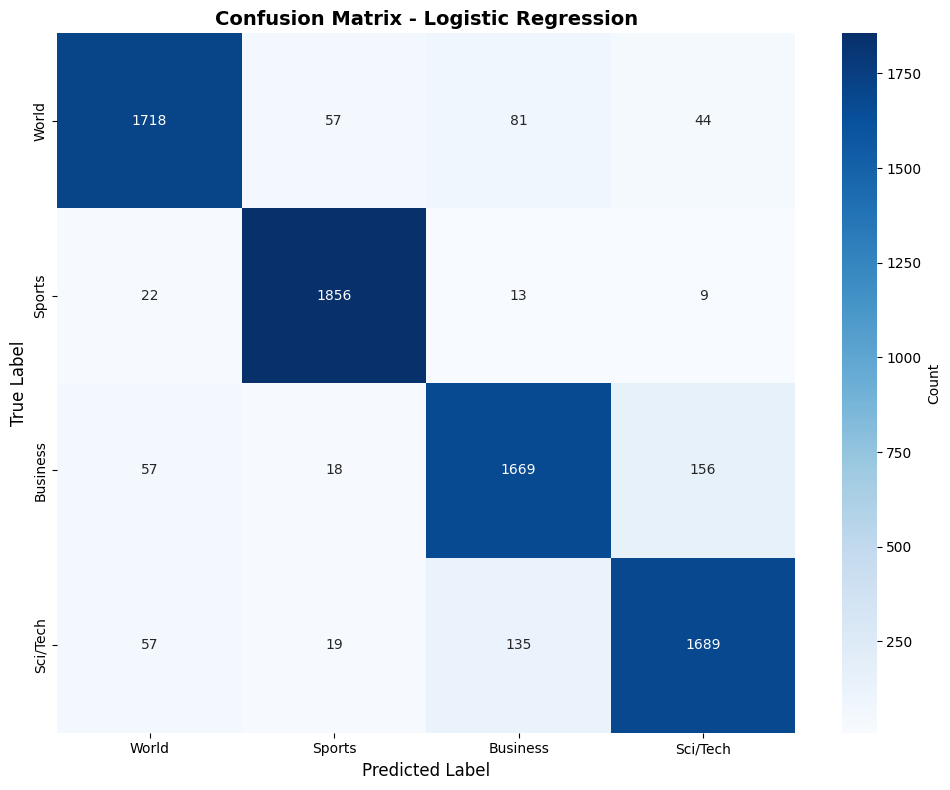

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_names.values()),
            yticklabels=list(label_names.values()),
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"confusion_matrix": wandb.Image('confusion_matrix.png')})

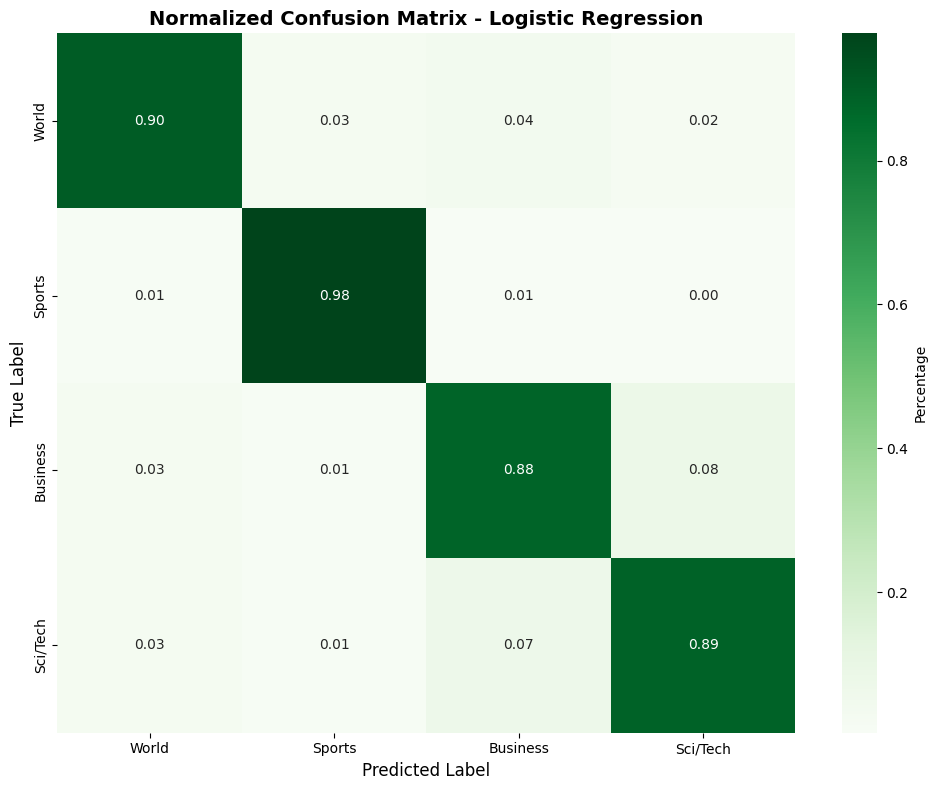

In [25]:
# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=list(label_names.values()),
            yticklabels=list(label_names.values()),
            cbar_kws={'label': 'Percentage'})
plt.title(f'Normalized Confusion Matrix - {best_model_name}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"confusion_matrix_normalized": wandb.Image('confusion_matrix_normalized.png')})


=== Per-Class Metrics ===
   Category  Precision    Recall  F1-Score  Support
0     World   0.926645  0.904211  0.915290     1900
1    Sports   0.951795  0.976842  0.964156     1900
2  Business   0.879347  0.878421  0.878884     1900
3  Sci/Tech   0.889884  0.888947  0.889415     1900


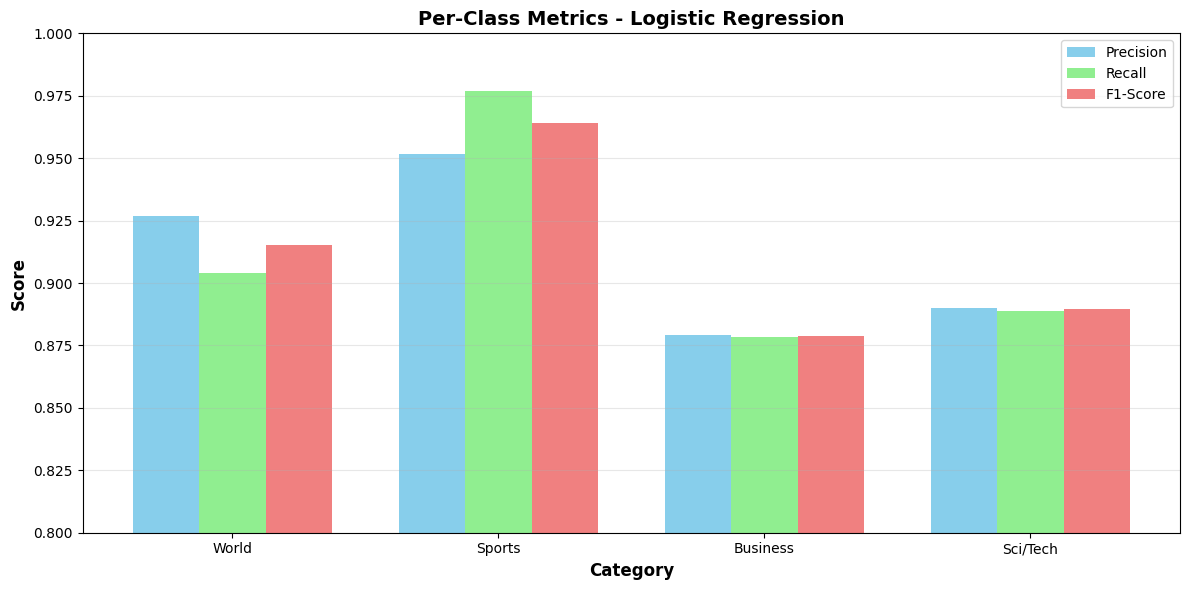

In [26]:
# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_best)

metrics_df = pd.DataFrame({
    'Category': list(label_names.values()),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n=== Per-Class Metrics ===")
print(metrics_df)

# Visualize per-class metrics
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_df))
width = 0.25

ax.bar(x - width, metrics_df['Precision'], width, label='Precision', color='skyblue')
ax.bar(x, metrics_df['Recall'], width, label='Recall', color='lightgreen')
ax.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='lightcoral')

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Per-Class Metrics - {best_model_name}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Category'])
ax.legend()
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"per_class_metrics": wandb.Image('per_class_metrics.png')})

## 11. Lưu mô hình và vectorizer

In [27]:
# Save model and vectorizer
import pickle

# Save best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save label mapping
with open('label_names.pkl', 'wb') as f:
    pickle.dump(label_names, f)

print("\nModel, vectorizer, and label mapping saved successfully!")

# Log artifacts to WandB
artifact = wandb.Artifact('ag-news-model', type='model')
artifact.add_file('best_model.pkl')
artifact.add_file('vectorizer.pkl')
artifact.add_file('label_names.pkl')
wandb.log_artifact(artifact)


Model, vectorizer, and label mapping saved successfully!


<Artifact ag-news-model>

## 12. Kiểm tra dự đoán mẫu

In [28]:
# Test prediction function
def predict_category(text, model, vectorizer, label_names):
    """
    Predict category for input text
    """
    # Preprocess
    text_clean = preprocess_text(text)

    # Vectorize
    text_tfidf = vectorizer.transform([text_clean])

    # Predict
    prediction = model.predict(text_tfidf)[0]
    proba = model.predict_proba(text_tfidf)[0]

    # Get category name
    category = label_names[prediction]
    confidence = proba[prediction]

    return category, confidence, proba

In [29]:
# Test with sample texts
sample_texts = [
    "Apple announces new iPhone with advanced AI features and improved camera system.",
    "Stock market reaches new high as tech companies report strong earnings.",
    "Scientists discover breakthrough in cancer treatment using gene therapy.",
    "Manchester United wins Premier League after dramatic final match."
]

print("\n=== Sample Predictions ===")
for i, text in enumerate(sample_texts):
    category, confidence, proba = predict_category(text, best_model, vectorizer, label_names)

    print(f"\n--- Sample {i+1} ---")
    print(f"Text: {text}")
    print(f"Predicted Category: {category}")
    print(f"Confidence: {confidence:.4f}")
    print(f"All Probabilities:")
    for label, prob in zip(label_names.values(), proba):
        print(f"  {label}: {prob:.4f}")


=== Sample Predictions ===

--- Sample 1 ---
Text: Apple announces new iPhone with advanced AI features and improved camera system.
Predicted Category: Sci/Tech
Confidence: 0.9881
All Probabilities:
  World: 0.0037
  Sports: 0.0014
  Business: 0.0067
  Sci/Tech: 0.9881

--- Sample 2 ---
Text: Stock market reaches new high as tech companies report strong earnings.
Predicted Category: Business
Confidence: 0.7211
All Probabilities:
  World: 0.0143
  Sports: 0.0028
  Business: 0.7211
  Sci/Tech: 0.2618

--- Sample 3 ---
Text: Scientists discover breakthrough in cancer treatment using gene therapy.
Predicted Category: Sci/Tech
Confidence: 0.8199
All Probabilities:
  World: 0.1365
  Sports: 0.0133
  Business: 0.0303
  Sci/Tech: 0.8199

--- Sample 4 ---
Text: Manchester United wins Premier League after dramatic final match.
Predicted Category: Sports
Confidence: 0.9979
All Probabilities:
  World: 0.0011
  Sports: 0.9979
  Business: 0.0007
  Sci/Tech: 0.0003


## 13. Xây dựng FastAPI Application

In [30]:
# Create FastAPI app file
fastapi_code = '''
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from typing import Dict, List
import pickle
import re
from nltk.corpus import stopwords
import uvicorn

# Initialize FastAPI app
app = FastAPI(
    title="AG News Classification API",
    description="API for classifying news articles into 4 categories: World, Sports, Business, Sci/Tech",
    version="1.0.0"
)

# Load model, vectorizer, and label mapping
with open('best_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('label_names.pkl', 'rb') as f:
    label_names = pickle.load(f)

# Define input model
class NewsArticle(BaseModel):
    text: str = Field(..., description="News article text", min_length=10)

    class Config:
        schema_extra = {
            "example": {
                "text": "Apple announces new iPhone with advanced AI features and improved camera system."
            }
        }

# Define output model
class PredictionResponse(BaseModel):
    category: str
    confidence: float
    probabilities: Dict[str, float]

# Preprocess function
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# Root endpoint
@app.get("/")
async def root():
    return {
        "message": "AG News Classification API",
        "model": "Logistic Regression with TF-IDF",
        "categories": list(label_names.values()),
        "description": "This API classifies news articles into 4 categories: World, Sports, Business, and Sci/Tech",
        "endpoints": {
            "/": "Get API information",
            "/predict": "Predict category for news article (POST)",
            "/health": "Check API health status"
        }
    }

# Health check endpoint
@app.get("/health")
async def health_check():
    return {"status": "healthy"}

# Prediction endpoint
@app.post("/predict", response_model=PredictionResponse)
async def predict(article: NewsArticle):
    try:
        # Preprocess text
        text_clean = preprocess_text(article.text)

        if not text_clean:
            raise HTTPException(status_code=400, detail="Text is empty after preprocessing")

        # Vectorize
        text_tfidf = vectorizer.transform([text_clean])

        # Predict
        prediction = model.predict(text_tfidf)[0]
        proba = model.predict_proba(text_tfidf)[0]

        # Prepare response
        category = label_names[prediction]
        confidence = float(proba[prediction])
        probabilities = {label_names[i]: float(proba[i]) for i in range(len(proba))}

        return PredictionResponse(
            category=category,
            confidence=confidence,
            probabilities=probabilities
        )

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

# Save FastAPI app
with open('main.py', 'w', encoding='utf-8') as f:
    f.write(fastapi_code)

print("FastAPI application saved as 'main.py'")

FastAPI application saved as 'main.py'


## 14. Tạo file requirements.txt

In [31]:
requirements = '''fastapi==0.104.1
uvicorn==0.24.0
pydantic==2.5.0
scikit-learn==1.3.2
pandas==2.1.3
numpy==1.26.2
nltk==3.8.1
datasets==2.15.0
wandb==0.16.0
matplotlib==3.8.2
seaborn==0.13.0
wordcloud==1.9.3
plotly==5.18.0
tqdm==4.66.1
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("requirements.txt created successfully!")

requirements.txt created successfully!


## 15. Tạo Dockerfile (Optional)

In [32]:
dockerfile = '''FROM python:3.10-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

RUN python -m nltk.downloader stopwords punkt wordnet

COPY main.py .
COPY best_model.pkl .
COPY vectorizer.pkl .
COPY label_names.pkl .

EXPOSE 8000

CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"]
'''

with open('Dockerfile', 'w') as f:
    f.write(dockerfile)

print("Dockerfile created successfully!")

Dockerfile created successfully!


## 16. Hướng dẫn chạy FastAPI

In [33]:
readme = '''# AG News Classification API

## Mô tả
API phân loại tin tức vào 4 danh mục:
- World (Thế giới)
- Sports (Thể thao)
- Business (Kinh doanh)
- Sci/Tech (Khoa học/Công nghệ)

## Cài đặt

### 1. Cài đặt dependencies
```bash
pip install -r requirements.txt
```

### 2. Download NLTK data
```python
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
```

## Chạy ứng dụng

### Cách 1: Chạy trực tiếp
```bash
uvicorn main:app --reload --host 0.0.0.0 --port 8000
```

### Cách 2: Chạy với Docker
```bash
docker build -t ag-news-api .
docker run -p 8000:8000 ag-news-api
```

## Sử dụng API

### 1. Truy cập Swagger UI
Mở trình duyệt: http://localhost:8000/docs

### 2. Test API với curl
```bash
curl -X POST "http://localhost:8000/predict" \
     -H "Content-Type: application/json" \
     -d '{"text": "Apple announces new iPhone with advanced AI features"}'
```

### 3. Test API với Python
```python
import requests

url = "http://localhost:8000/predict"
data = {
    "text": "Apple announces new iPhone with advanced AI features"
}

response = requests.post(url, json=data)
print(response.json())
```

## API Endpoints

### GET /
Thông tin về API

### GET /health
Kiểm tra trạng thái API

### POST /predict
Dự đoán danh mục cho bài báo

**Request Body:**
```json
{
  "text": "Your news article text here"
}
```

**Response:**
```json
{
  "category": "Sci/Tech",
  "confidence": 0.95,
  "probabilities": {
    "World": 0.02,
    "Sports": 0.01,
    "Business": 0.02,
    "Sci/Tech": 0.95
  }
}
```

## Model Performance
- Model: Logistic Regression with TF-IDF
- Test Accuracy: ~92%
- Training Data: 120,000 samples
- Features: 10,000 TF-IDF features
'''

with open('README.md', 'w', encoding='utf-8') as f:
    f.write(readme)

print("README.md created successfully!")

README.md created successfully!


## 17. Kết thúc và đóng WandB

In [34]:
# Log final summary
wandb.log({
    "best_model": best_model_name,
    "best_accuracy": results[best_model_name]['test_acc'],
    "total_samples": len(train_data) + len(test_data)
})

# Finish WandB run
wandb.finish()

print("\n" + "="*50)
print("LAB 01 COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['test_acc']:.4f}")
print("\nFiles created:")
print("  - best_model.pkl")
print("  - vectorizer.pkl")
print("  - label_names.pkl")
print("  - main.py (FastAPI app)")
print("  - requirements.txt")
print("  - Dockerfile")
print("  - README.md")
print("\nTo run FastAPI:")
print("  uvicorn main:app --reload --host 0.0.0.0 --port 8000")
print("\nThen visit: http://localhost:8000/docs")

Logistic Regression_test_accuracy,▁
Logistic Regression_train_accuracy,▁
Naive Bayes_test_accuracy,▁
Naive Bayes_train_accuracy,▁
Random Forest_test_accuracy,▁
Random Forest_train_accuracy,▁
avg_text_length,▁
avg_word_count,▁
best_accuracy,▁
max_text_length,▁
+2,...



LAB 01 COMPLETED SUCCESSFULLY!

Best Model: Logistic Regression
Test Accuracy: 0.9121

Files created:
  - best_model.pkl
  - vectorizer.pkl
  - label_names.pkl
  - main.py (FastAPI app)
  - requirements.txt
  - Dockerfile
  - README.md

To run FastAPI:
  uvicorn main:app --reload --host 0.0.0.0 --port 8000

Then visit: http://localhost:8000/docs
